<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/neb_al_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics

     |████████████████████████████████| 296kB 2.8MB/s 
     |████████████████████████████████| 6.7MB 43.2MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 2.1MB 33.9MB/s 
     |████████████████████████████████| 12.8MB 243kB/s 
     |████████████████████████████████| 110.5MB 37kB/s 
     |████████████████████████████████| 512kB 42.4MB/s 
     |████████████████████████████████| 3.8MB 36.1MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... done
     |████████████████████████████████| 102kB 2.4MB/s 


In [2]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.build import fcc100, add_adsorbate
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 


In [0]:
def attach_sp_calc(image):
  sample_energy = image.get_potential_energy(apply_constraint=False)
  sample_forces = image.get_forces(apply_constraint=False)
  image.set_calculator(
      sp(atoms=image, energy=sample_energy, forces=sample_forces)
  )
  return image

class CounterCalc(Calculator):
  implemented_properties = ["energy", "forces"]

  def __init__(self, calc):
    super().__init__()
    self.calc = calc
    self.force_calls = 0

  def calculate(self, atoms, properties, system_changes):
    super().calculate(atoms, properties, system_changes)
    calc = copy.deepcopy(self.calc)
    self.results["energy"] = calc.get_potential_energy(atoms)
    self.results["forces"] = calc.get_forces(atoms)
    self.force_calls += 1


class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      self.starting_images = starting_images
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      initial = self.starting_images[0]
      final = self.starting_images[-1]

      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial.copy()
        ml_initial.set_calculator(calc)
        ml_final = final.copy()
        ml_final.set_calculator(calc)
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=200)
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=200)

      initial = read("initial.traj", "-1")
      final = read("final.traj", "-1")

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=200)
      print('NEB DONE')

    def get_trajectory(self, filename, start_count, end_count, interval):
      trajectory = ase.io.read(
        filename + ".traj", "{}:{}:{}".format(start_count, end_count, interval)
      )
      return trajectory

In [0]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers

#Building your structure
def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc)
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    qn = QuasiNewton(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=200)
    qn = QuasiNewton(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=200)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

In [12]:
# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Define morse parameters if Delta-ML model, o/w morse = False
morse = True
morse_params = {
    "C": {"re": 0.972, "D": 6.379, "sig": 0.477},
    "O": {"re": 1.09, "D": 8.575, "sig": 0.603},
    "Cu": {"re": 2.168, "D": 3.8386, "sig": 1.696},
}

training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 3},
      "samples_to_retrain": 5,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 1,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 200,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "neb_example",
      "file_dir": "./"
}

ml2relax = False
parent_calc = EMT()
initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
images = [initial, final]

# Define AL scheme
learner = AtomisticActiveLearner(
    training_data=images,
    training_params=training_params,
    parent_calc=parent_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

learner.learn(
    atomistic_method=NEBcalc(
        starting_images=images, 
        ml2relax=ml2relax, 
        intermediate_samples=total_neb_images-2), 
		query_strategy=random_query
	)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.1162         61.9710      153.6297     +  0.1111
      2          0.1134          7.6431        2.3496     +  0.1189
      3          0.1125          3.8535        0.6067     +  0.1318
      4          0.1081          3.2219        0.4269     +  0.1450
      5          0.0955          1.7274        0.1285     +  0.1767
      6          0.0942          1.5576        0.1059     +  0.1649
      7          0.0899          1.4097        0.0876     +  0.1737
      8          0.0865          1.3751        0.0831     +  0.1689
      9          0.0801          1.3460        0.0789     +  0.1599
     10          0.0730          1.3332        0.0764     +  0.1695
     11          0.0562          1.3218        0.0730     +  0.1588
     12          0.0044          1.2433        0.0618     +  0.

Visualize AL Results

ML barrier pred = 0.14066676343808843, ml dE pred = 1.082219940196083e-05, ml max force = 0.008808617704113942
emt@ml barrier = 0.12977161150122843, emt@ml dE = 1.082219940196083e-05, emt@ml max force = 0.04762488296277351
AL: Total number of force calls = 31 (initial data) + 15 (AL-NEB) = 46


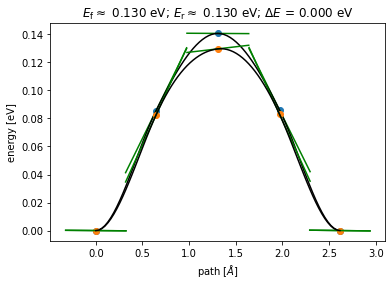

In [13]:
def neb_analysis(images, label, ax=None):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  fig.savefig(label+'.png', dpi=300)
  return barrier, dE, max_force



images = read(f'neb_example_iter_3.traj@-{total_neb_images}:')

# to verify ml_computed images...evaluate with parent calculator
emt_evaluated_images = []
for image in images:
  image = image.copy()
  image.set_calculator(EMT())
  emt_evaluated_images.append(image)

barrier_ml, dE_ml, max_force_ml = neb_analysis(images, label="ml_diffusion_neb")
barrier_emt_ml, dE_emt_ml, max_force_emt_ml = neb_analysis(emt_evaluated_images, label="emt@ml_diffusion_neb")
print(f"ML barrier pred = {barrier_ml}, ml dE pred = {dE_ml}, ml max force = {max_force_ml}")
print(f"emt@ml barrier = {barrier_emt_ml}, emt@ml dE = {dE_emt_ml}, emt@ml max force = {max_force_emt_ml}")
print(f"AL: Total number of force calls = {initial_force_calls} (initial data) + {learner.parent_calls} (AL-NEB) = {initial_force_calls+learner.parent_calls}")

#### Code to generate true NEB

In [14]:
emt_counter = CounterCalc(EMT())

if not ml2relax:
  # Load previously computed relaxed states
  initial_slab = read("initial.traj", "-1")
  final_slab = read("final.traj", "-1")
else:
  initial_slab.set_calculator(emt_counter)
  final_slab.set_calculator(emt_counter)
  qn = QuasiNewton(initial_slab, trajectory='parent_initial.traj', logfile='initial_relax_log.txt')
  qn.run(fmax=0.01, steps=200)
  qn = QuasiNewton(final_slab, trajectory='parent_final.traj', logfile='final_relax_log.txt')
  qn.run(fmax=0.01, steps=200)
  initial_slab = read("parent_initial.traj", "-1")
  final_slab = read("parent_final.traj", "-1")

images = [initial]
for i in range(3):
    image = final.copy()
    image.set_calculator(emt_counter)
    images.append(image)
images.append(final)

neb = SingleCalculatorNEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb.traj')
qn.run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 00:10:15        4.222858        4.3067
BFGS:    1 00:10:16        3.947671        2.8886
BFGS:    2 00:10:16        3.793445        1.7838
BFGS:    3 00:10:16        3.721149        0.9349
BFGS:    4 00:10:16        3.697492        0.3497
BFGS:    5 00:10:16        3.690960        0.4067
BFGS:    6 00:10:17        3.676023        0.4033
BFGS:    7 00:10:17        3.665892        0.2970
BFGS:    8 00:10:17        3.660757        0.1845
BFGS:    9 00:10:17        3.659329        0.1570
BFGS:   10 00:10:18        3.658204        0.1398
BFGS:   11 00:10:18        3.656267        0.1019
BFGS:   12 00:10:18        3.655090        0.0763
BFGS:   13 00:10:18        3.654954        0.0357
BFGS:   14 00:10:18        3.654962        0.0185
BFGS:   15 00:10:19        3.654946        0.0132
BFGS:   16 00:10:19        3.654933        0.0075


True

Ef = 0.12946476907802576, dE = 1.082219940196083e-05, max_force = 0.007450782039978097
Total number of force calls = 31 (initial data) + 51 (AL-NEB) = 82


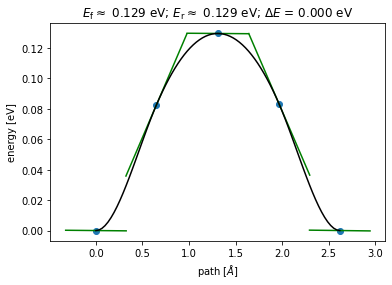

In [15]:
images = read(f'actual_neb.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

fig = nebtools.plot_band()
fig.savefig('diffusion-barrier2.png')

print(f"Ef = {Ef}, dE = {dE}, max_force = {max_force}")
print(f"Total number of force calls = {initial_force_calls} (initial data) + {emt_counter.force_calls} (AL-NEB) = {initial_force_calls+emt_counter.force_calls}")